In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
import os
import gc

In [2]:
print(os.getcwd())

model_repr = {
    "mab": "K-armed Bandit", 
    "ucbnaive": "Naive UCB Approach", 
    "ucbdelta": "UCB-delta Algorithm", 
    "ucbasym": "Asymptotically Optimal UCB", 
    "ucbmoss": "UCB MOSS Algorithm", 
    "thompson": "Thompson Sampling",
    "etc": "Explore-then-commit"
}

model_params = {
    "mab": "epsilon", 
    "ucbnaive": "c", 
    "ucbdelta": "delta", 
    "etc": "explore"  
}

/home/sungwoopark/rl-practice/bandit/MAB


In [3]:
def process(df:pd.DataFrame, no_param:bool):
    ## get cumulative reward
    cumsum_base = np.array([], dtype='float')
    for e in df['sim'].unique():
        rundf = df[df['sim'] == e]
        run_cumsum = np.cumsum(rundf['reward'])
        cumsum_base = np.append(cumsum_base, run_cumsum)
    df['cumulative_reward'] = cumsum_base
    
    ## check if the optimal arm is selected at each run
    df['chosen_optimal'] = (df['chosen_arm'] == df['optimal_arm']).astype('int')
    
    ## groupby
    if no_param:
        result = df[['step', 'reward', 'mean_reward', 'cumulative_reward', 'optimal_reward']].groupby(by='step').mean(numeric_only=False)
    else:
        result = df[['param', 'step', 'reward', 'mean_reward', 'cumulative_reward', 'optimal_reward']].groupby(by=['param', 'step']).mean(numeric_only=False)
    result.reset_index(drop=False, inplace=True)
    
    return result

In [4]:
def getlabel(colname:str):
    split = colname.split('_')
    split[0] = split[0][0].upper() + split[0][1:]
    label = ' '.join(split)
    return label

In [21]:
def plot_results(dfs, model, arm, columns='regret', figsize=(16, 6)):
    ylabel = getlabel(columns)
    plt.figure(figsize=figsize)
    for item in dfs:
        if model in ["thompson", "ucbasym", "ucbmoss"]:
            label = f"{model_repr[model]}"
        else:
            label = f"{model_params[model]}={item['param'].iloc[0]}"
        plt.plot(item[columns], label=label)
    plt.legend()
    plt.grid(True)
    plt.xlabel("Step")
    plt.ylabel(ylabel)
    plt.title(f"{model_repr[model]} {ylabel} - {arm} Arm")
    
    plt.tight_layout()
    plt.show()

In [6]:
def procedure(fname, no_param):
    with open(fname, "rb") as f:
        obj = pickle.load(f)
    
    processed = []
    for df in tqdm(obj):
        processed.append(process(df, no_param))
    
    del obj
    gc.collect()
    return processed

In [7]:
def summary(dfs, model, column, greedy, is_optimistic=False):
    if is_optimistic:
        flag = "Optimistic "
    else:
        flag = ""
        
    means = [item[column].mean() for item in dfs]
    argmax = np.argmax(means)

    if greedy:
        label = f"{flag}{model_repr[model]}, greedy"
        argmax = 0
    else:
        best_param = dfs[argmax]['param'].iloc[0]
        label = f"{flag}{model_repr[model]}, {model_params[model]}={best_param}"
    
    return argmax, label

In [8]:
os.chdir("./definite")
!ls

eGreedyMAB_BernoulliArm_0.5_Naive_results.pkl
eGreedyMAB_BernoulliArm_0.5_Optimistic_results.pkl
eGreedyMAB_BernoulliArm_1.0_Naive_results.pkl
eGreedyMAB_BernoulliArm_1.0_Optimistic_results.pkl
eGreedyMAB_GaussianArm_0.5_Naive_results.pkl
eGreedyMAB_GaussianArm_0.5_Optimistic_results.pkl
eGreedyMAB_GaussianArm_1.0_Naive_results.pkl
eGreedyMAB_GaussianArm_1.0_Optimistic_results.pkl
ETC_BernoulliArm_1.0_Naive_results.pkl
ETC_GaussianArm_1.0_Naive_results.pkl
ThompsonSampling_BernoulliArm_1.0_Naive_results.pkl
ThompsonSampling_GaussianArm_1.0_Naive_results.pkl
UCBAsymptotic_BernoulliArm_1.0_Naive_results.pkl
UCBAsymptotic_GaussianArm_1.0_Naive_results.pkl
UCBDelta_BernoulliArm_1.0_Naive_results.pkl
UCBDelta_GaussianArm_1.0_Naive_results.pkl
UCBMOSS_BernoulliArm_1.0_Naive_results.pkl
UCBMOSS_GaussianArm_1.0_Naive_results.pkl
UCBNaive_BernoulliArm_1.0_Naive_results.pkl
UCBNaive_GaussianArm_1.0_Naive_results.pkl


In [10]:
getlabel('regret')

'Regret'

In [11]:
mab_gaus_1 = procedure(fname="./eGreedyMAB_GaussianArm_1.0_Naive_results.pkl", no_param=False)

100%|██████████| 6/6 [00:53<00:00,  8.92s/it]


In [12]:
for item in tqdm(mab_gaus_1):
    item['rnd_regret'] = np.cumsum(item['optimal_reward'] - item['reward'])
    item['regret'] = np.cumsum(item['optimal_reward'] - item['mean_reward'])
    display(item.head())
    display(item.tail())
    print(f"="*35)

  0%|          | 0/6 [00:00<?, ?it/s]

,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
0,0.0,0,0.158219,0.173435,0.158219,0.9,0.741781,0.726565
1,0.0,1,0.187280,0.190465,0.345499,0.9,1.454501,1.436100
2,0.0,2,0.183502,0.210485,0.529001,0.9,2.170999,2.125615
3,0.0,3,0.205970,0.218700,0.734971,0.9,2.865029,2.806915
4,0.0,4,0.237169,0.232325,0.972140,0.9,3.527860,3.474590


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
1995,0.0,1995,0.393297,0.387135,763.483735,0.9,1032.916265,1033.338865
1996,0.0,1996,0.358596,0.387135,763.842331,0.9,1033.457669,1033.851730
1997,0.0,1997,0.380114,0.387135,764.222445,0.9,1033.977555,1034.364595
1998,0.0,1998,0.388588,0.387135,764.611033,0.9,1034.488967,1034.877460
1999,0.0,1999,0.416821,0.387135,765.027854,0.9,1034.972146,1035.390325


 17%|█▋        | 1/6 [00:00<00:01,  4.58it/s]

,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
0,0.01,0,0.168862,0.187880,0.168862,0.9,0.731138,0.712120
1,0.01,1,0.214154,0.205555,0.383016,0.9,1.416984,1.406565
2,0.01,2,0.231112,0.215435,0.614128,0.9,2.085872,2.091130
3,0.01,3,0.228357,0.222965,0.842484,0.9,2.757516,2.768165
4,0.01,4,0.239001,0.231545,1.081485,0.9,3.418515,3.436620


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
1995,0.01,1995,0.678207,0.661080,1071.269492,0.9,725.130508,724.833225
1996,0.01,1996,0.644518,0.660600,1071.914011,0.9,725.385989,725.072625
1997,0.01,1997,0.622839,0.660825,1072.536850,0.9,725.663150,725.311800
1998,0.01,1998,0.684960,0.661270,1073.221810,0.9,725.878190,725.550530
1999,0.01,1999,0.640162,0.659350,1073.861972,0.9,726.138028,725.791180


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
0,0.1,0,0.162877,0.184870,0.162877,0.9,0.737123,0.715130
1,0.1,1,0.214469,0.200950,0.377346,0.9,1.422654,1.414180
2,0.1,2,0.234535,0.211095,0.611880,0.9,2.088120,2.103085
3,0.1,3,0.228320,0.221165,0.840200,0.9,2.759800,2.781920
4,0.1,4,0.234856,0.227835,1.075056,0.9,3.424944,3.454085


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
1995,0.1,1995,0.807754,0.824990,1500.000858,0.9,296.399142,296.338275
1996,0.1,1996,0.869301,0.834320,1500.870159,0.9,296.429841,296.403955
1997,0.1,1997,0.823021,0.826925,1501.693180,0.9,296.506820,296.477030
1998,0.1,1998,0.822781,0.825135,1502.515961,0.9,296.584039,296.551895
1999,0.1,1999,0.831957,0.825010,1503.347918,0.9,296.652082,296.626885


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
0,0.5,0,0.201275,0.178510,0.201275,0.9,0.698725,0.721490
1,0.5,1,0.152891,0.183295,0.354166,0.9,1.445834,1.438195
2,0.5,2,0.184801,0.196030,0.538967,0.9,2.161033,2.142165
3,0.5,3,0.225789,0.199505,0.764756,0.9,2.835244,2.842660
4,0.5,4,0.214824,0.205850,0.979580,0.9,3.520420,3.536810


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
1995,0.5,1995,0.564157,0.54463,1048.069815,0.9,748.330185,747.50579
1996,0.5,1996,0.546414,0.53644,1048.616229,0.9,748.683771,747.86935
1997,0.5,1997,0.557527,0.53804,1049.173756,0.9,749.026244,748.23131
1998,0.5,1998,0.537176,0.53993,1049.710932,0.9,749.389068,748.59138
1999,0.5,1999,0.541912,0.54498,1050.252845,0.9,749.747155,748.94640


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
0,0.9,0,0.159288,0.182280,0.159288,0.9,0.740712,0.717720
1,0.9,1,0.180688,0.183020,0.339975,0.9,1.460025,1.434700
2,0.9,2,0.214314,0.174605,0.554289,0.9,2.145711,2.160095
3,0.9,3,0.212699,0.183105,0.766988,0.9,2.833012,2.876990
4,0.9,4,0.269419,0.185855,1.036407,0.9,3.463593,3.591135


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
1995,0.9,1995,0.280392,0.256880,499.054501,0.9,1297.345499,1298.319695
1996,0.9,1996,0.257158,0.241450,499.311660,0.9,1297.988340,1298.978245
1997,0.9,1997,0.242424,0.257500,499.554083,0.9,1298.645917,1299.620745
1998,0.9,1998,0.241728,0.255765,499.795811,0.9,1299.304189,1300.264980
1999,0.9,1999,0.288797,0.258255,500.084608,0.9,1299.915392,1300.906725


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
0,1.0,0,0.172665,0.180425,0.172665,0.9,0.727335,0.719575
1,1.0,1,0.191079,0.174830,0.363745,0.9,1.436255,1.444745
2,1.0,2,0.209842,0.181080,0.573587,0.9,2.126413,2.163665
3,1.0,3,0.174521,0.180535,0.748108,0.9,2.851892,2.883130
4,1.0,4,0.190503,0.176155,0.938611,0.9,3.561389,3.606975


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
1995,1.0,1995,0.182976,0.171695,362.640669,0.9,1433.759331,1434.433135
1996,1.0,1996,0.144179,0.187415,362.784847,0.9,1434.515153,1435.145720
1997,1.0,1997,0.203462,0.183750,362.988309,0.9,1435.211691,1435.861970
1998,1.0,1998,0.184711,0.189860,363.173020,0.9,1435.926980,1436.572110
1999,1.0,1999,0.177910,0.183015,363.350931,0.9,1436.649069,1437.289095


100%|██████████| 6/6 [00:00<00:00, 21.38it/s]

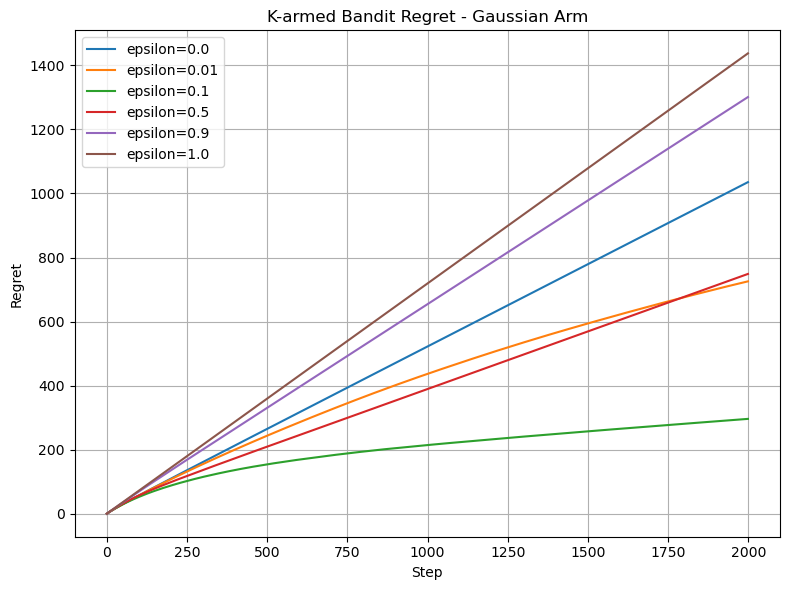

In [22]:
plot_results(mab_gaus_1, model="mab", arm="Gaussian", columns='regret', figsize=(8, 6))

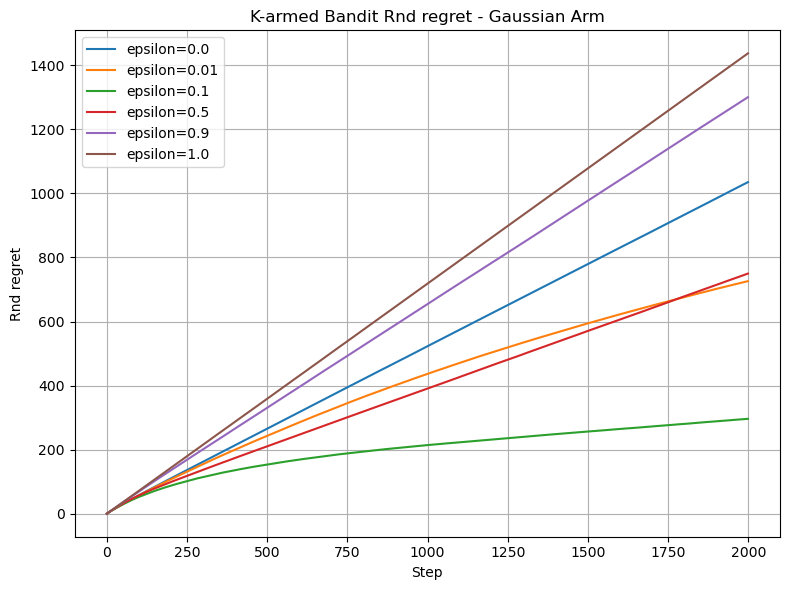

In [23]:
plot_results(mab_gaus_1, model="mab", arm="Gaussian", columns='rnd_regret', figsize=(8, 6))

In [24]:
ucbdelta_gaus_1 = procedure(fname="./UCBDelta_GaussianArm_1.0_Naive_results.pkl", no_param=False)

100%|██████████| 6/6 [00:52<00:00,  8.76s/it]


In [25]:
for item in tqdm(ucbdelta_gaus_1):
    item['rnd_regret'] = np.cumsum(item['optimal_reward'] - item['reward'])
    item['regret'] = np.cumsum(item['optimal_reward'] - item['mean_reward'])
    display(item.head())
    display(item.tail())
    print(f"="*35)

  0%|          | 0/6 [00:00<?, ?it/s]

,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
0,2.500000e-07,0,0.193111,0.182240,0.193111,0.9,0.706889,0.717760
1,2.500000e-07,1,0.180677,0.184920,0.373787,0.9,1.426213,1.432840
2,2.500000e-07,2,0.193436,0.175250,0.567224,0.9,2.132776,2.157590
3,2.500000e-07,3,0.179805,0.183975,0.747028,0.9,2.852972,2.873615
4,2.500000e-07,4,0.169874,0.173600,0.916902,0.9,3.583098,3.600015


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
1995,2.500000e-07,1995,0.885867,0.90000,1525.315029,0.9,271.084971,271.200595
1996,2.500000e-07,1996,0.919987,0.90000,1526.235016,0.9,271.064984,271.200595
1997,2.500000e-07,1997,0.913481,0.89961,1527.148497,0.9,271.051503,271.200985
1998,2.500000e-07,1998,0.860119,0.90000,1528.008617,0.9,271.091383,271.200985
1999,2.500000e-07,1999,0.927700,0.90000,1528.936317,0.9,271.063683,271.200985


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
0,0.01,0,0.170253,0.179925,0.170253,0.9,0.729747,0.720075
1,0.01,1,0.192123,0.177125,0.362377,0.9,1.437623,1.442950
2,0.01,2,0.148496,0.178015,0.510873,0.9,2.189127,2.164935
3,0.01,3,0.157729,0.184980,0.668602,0.9,2.931398,2.879955
4,0.01,4,0.177295,0.177660,0.845898,0.9,3.654102,3.602295


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
1995,0.01,1995,0.884278,0.88737,1677.950417,0.9,118.449583,116.998785
1996,0.01,1996,0.904862,0.88737,1678.855279,0.9,118.444721,117.011415
1997,0.01,1997,0.907116,0.88737,1679.762394,0.9,118.437606,117.024045
1998,0.01,1998,0.863937,0.88737,1680.626332,0.9,118.473668,117.036675
1999,0.01,1999,0.893253,0.88737,1681.519584,0.9,118.480416,117.049305


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
0,0.1,0,0.213353,0.181160,0.213353,0.9,0.686647,0.718840
1,0.1,1,0.199703,0.185375,0.413056,0.9,1.386944,1.433465
2,0.1,2,0.199310,0.190040,0.612366,0.9,2.087634,2.143425
3,0.1,3,0.180997,0.182385,0.793362,0.9,2.806638,2.861040
4,0.1,4,0.167192,0.175565,0.960554,0.9,3.539446,3.585475


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
1995,0.1,1995,0.869490,0.850545,1644.568976,0.9,151.831024,152.843075
1996,0.1,1996,0.841666,0.850520,1645.410642,0.9,151.889358,152.892555
1997,0.1,1997,0.875786,0.850520,1646.286428,0.9,151.913572,152.942035
1998,0.1,1998,0.824883,0.850520,1647.111311,0.9,151.988689,152.991515
1999,0.1,1999,0.872373,0.850520,1647.983685,0.9,152.016315,153.040995


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
0,0.5,0,0.150317,0.174735,0.150317,0.9,0.749683,0.725265
1,0.5,1,0.175262,0.182250,0.325579,0.9,1.474421,1.443015
2,0.5,2,0.165435,0.184070,0.491014,0.9,2.208986,2.158945
3,0.5,3,0.186882,0.177390,0.677896,0.9,2.922104,2.881555
4,0.5,4,0.186348,0.178525,0.864243,0.9,3.635757,3.603030


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
1995,0.5,1995,0.746202,0.776285,1513.122466,0.9,283.277534,282.882485
1996,0.5,1996,0.771495,0.776285,1513.893961,0.9,283.406039,283.006200
1997,0.5,1997,0.780561,0.776285,1514.674523,0.9,283.525477,283.129915
1998,0.5,1998,0.781634,0.776285,1515.456156,0.9,283.643844,283.253630
1999,0.5,1999,0.790458,0.776285,1516.246615,0.9,283.753385,283.377345


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
0,0.9,0,0.179432,0.184895,0.179432,0.9,0.720568,0.715105
1,0.9,1,0.178181,0.179405,0.357613,0.9,1.442387,1.435700
2,0.9,2,0.180169,0.182390,0.537782,0.9,2.162218,2.153310
3,0.9,3,0.205782,0.196510,0.743564,0.9,2.856436,2.856800
4,0.9,4,0.191480,0.180560,0.935044,0.9,3.564956,3.576240


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
1995,0.9,1995,0.694570,0.683405,1334.784057,0.9,461.615943,461.849115
1996,0.9,1996,0.639199,0.683405,1335.423255,0.9,461.876745,462.065710
1997,0.9,1997,0.680087,0.683405,1336.103343,0.9,462.096657,462.282305
1998,0.9,1998,0.650252,0.683415,1336.753594,0.9,462.346406,462.498890
1999,0.9,1999,0.701062,0.683405,1337.454657,0.9,462.545343,462.715485


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
0,0.99,0,0.172615,0.185675,0.172615,0.9,0.727385,0.714325
1,0.99,1,0.170058,0.182130,0.342673,0.9,1.457327,1.432195
2,0.99,2,0.208186,0.183960,0.550858,0.9,2.149142,2.148235
3,0.99,3,0.195425,0.185675,0.746283,0.9,2.853717,2.862560
4,0.99,4,0.151598,0.179495,0.897881,0.9,3.602119,3.583065


,param,step,reward,mean_reward,cumulative_reward,optimal_reward,rnd_regret,regret
1995,0.99,1995,0.672712,0.689255,1343.094612,0.9,453.305388,451.542440
1996,0.99,1996,0.687796,0.689310,1343.782408,0.9,453.517592,451.753130
1997,0.99,1997,0.680054,0.689255,1344.462462,0.9,453.737538,451.963875
1998,0.99,1998,0.675957,0.689255,1345.138419,0.9,453.961581,452.174620
1999,0.99,1999,0.687984,0.689255,1345.826402,0.9,454.173598,452.385365


100%|██████████| 6/6 [00:00<00:00, 80.71it/s]

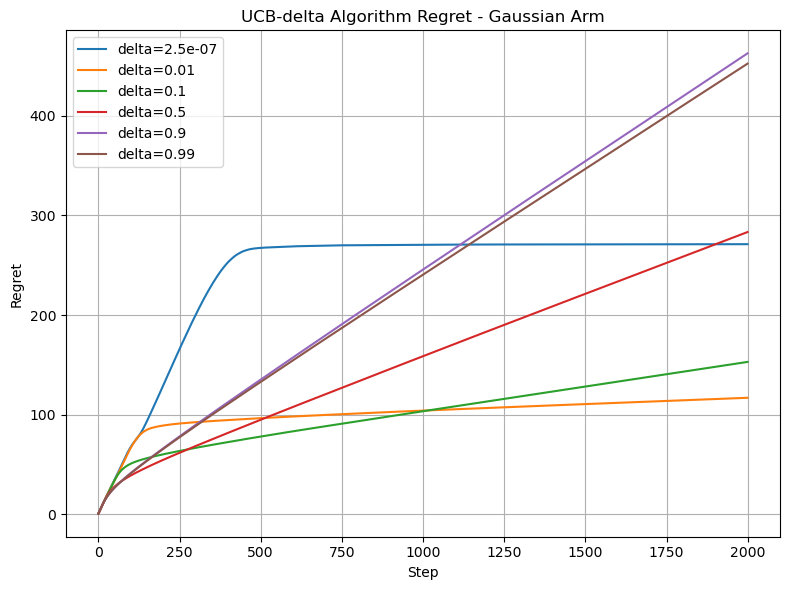

In [26]:
plot_results(ucbdelta_gaus_1, model="ucbdelta", arm="Gaussian", columns='regret', figsize=(8, 6))

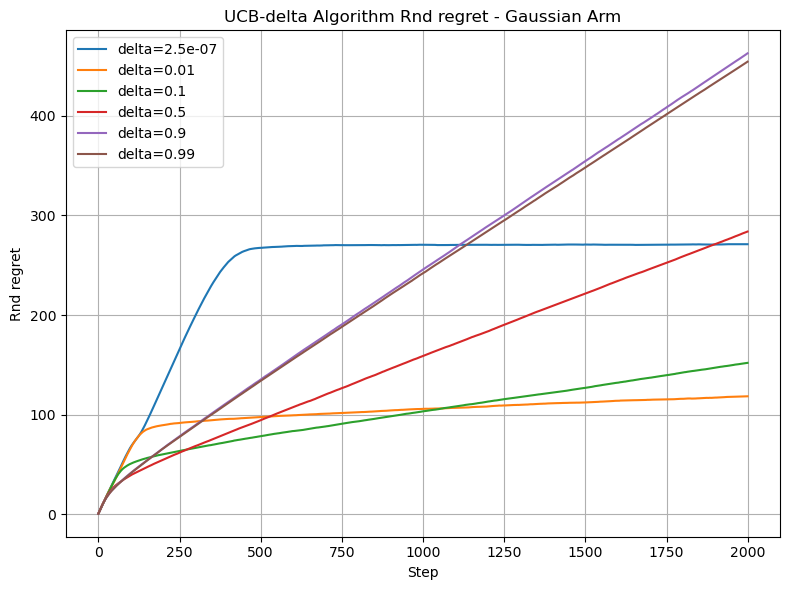

In [27]:
plot_results(ucbdelta_gaus_1, model="ucbdelta", arm="Gaussian", columns='rnd_regret', figsize=(8, 6))